PROBLEM STATEMENT 
The objective of this project is to apply unsupervised machine learning techniques to cluster Instagram users
based on their visit frequency and spending rank. The goal is to identify meaningful user segments that can help
businesses optimize marketing strategies, personalize content, and improve customer engagement.

In [1]:
import pandas as pd 
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


Silhouette Score = What it is: Measures how similar a data point is to
its own cluster compared to other clusters, indicating cohesion and separation.
#Davies-Bouldin Index (DBI);
 What it is: Calculates the average similarity ratio between each cluster and its most similar (closest) cluster, 
combining tightness (within-cluster distance) and separation (between-cluster distance).

In [3]:
df = pd.read_csv('Instagram visits clustering.csv')

In [4]:
df.head()

,User ID,Instagram visit score,Spending_rank(0 to 100)
0,0,63,24.050708
1,1,61,25.223290
2,2,104,18.528245
3,3,82,86.890232
4,4,14,31.492397


In [5]:
df.describe()

,User ID,Instagram visit score,Spending_rank(0 to 100)
count,2600.000000,2600.000000,2600.000000
mean,1299.500000,63.323462,42.848408
std,750.699674,26.579760,28.758349
min,0.000000,5.000000,0.940709
25%,649.750000,38.000000,19.452098
50%,1299.500000,72.000000,28.013082
75%,1949.250000,86.000000,72.116945
max,2599.000000,118.000000,107.349821


In [6]:
df.shape

(2600, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User ID                  2600 non-null   int64  
 1   Instagram visit score    2600 non-null   int64  
 2   Spending_rank(0 to 100)  2600 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 61.1 KB


In [8]:
df.isnull().sum()

User ID                    0
Instagram visit score      0
Spending_rank(0 to 100)    0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(0)

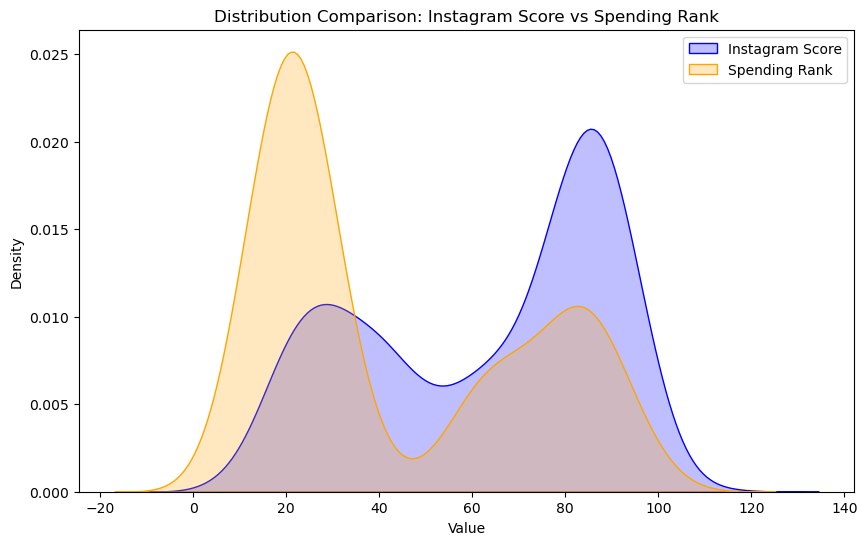

In [10]:
plt.figure(figsize=(10, 6))

# Plotting both distributions
sns.kdeplot(df['Instagram visit score'], fill=True, label='Instagram Score', color="blue")
sns.kdeplot(df['Spending_rank(0 to 100)'], fill=True, label='Spending Rank', color="orange")

plt.title('Distribution Comparison: Instagram Score vs Spending Rank')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram.
KDE represents the data using a continuous probability density curve in one or more dimensions.
why we use / plot kde is to understand feature distribution by visulization .

In [11]:
df.skew()

User ID                    0.000000
Instagram visit score     -0.405783
Spending_rank(0 to 100)    0.549969
dtype: float64

In [12]:
# LOG TRANSFORM
cols_to_transform = ['Spending_rank(0 to 100)',	'Instagram visit score']
for col in cols_to_transform:
    df[col] = np.log(df[col] + 1)

In [13]:
df.skew()

User ID                    0.000000
Instagram visit score     -1.032698
Spending_rank(0 to 100)   -0.140079
dtype: float64

In [14]:
# SQRT transform 
cols_sqrt = ['Spending_rank(0 to 100)'	,'Instagram visit score']
for col in cols_sqrt:
    df[col] = np.sqrt(df[col])

In [15]:
df.skew()

User ID                    0.000000
Instagram visit score     -1.181455
Spending_rank(0 to 100)   -0.409899
dtype: float64

In [16]:
# LAMDA transform 
cols = ['Spending_rank(0 to 100)'	,'Instagram visit score']
for col in cols:
    df[col] = df[col].apply(lambda x: x if x > 0 else 0.0001)

In [17]:
df.skew()

User ID                    0.000000
Instagram visit score     -1.181455
Spending_rank(0 to 100)   -0.409899
dtype: float64

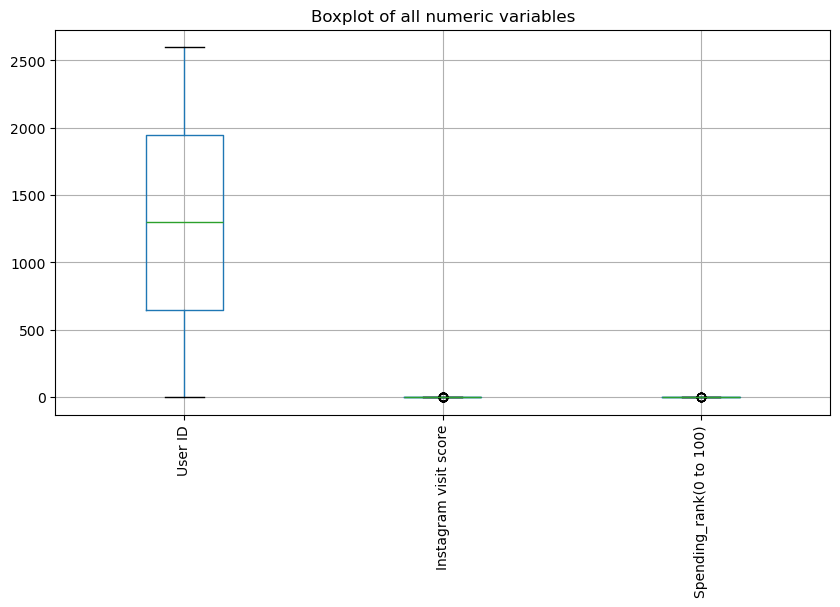

In [18]:
plt.figure(figsize=(10,5))  # Adjust size for many columns
df.boxplot(rot=90)           # Rotate x-axis labels for readability
plt.title("Boxplot of all numeric variables")
plt.show()

Why these outliers appear clearly here?
Because:
Instagram score & Spending rank have small numeric ranges
Even small deviations become visible
User ID dominates scale, compressing others visually
📌 That’s why the boxes of Instagram & Spending look flattened

In [37]:
print(df.columns)

Index(['User ID', 'Instagram visit score', 'Spending_rank(0 to 100)',
       'Cluster'],
      dtype='object')


In [19]:
df.columns = df.columns.str.strip() #Clean the column names just in case there are hidden spaces

In [20]:
print("Your available columns are:")
print(df.columns.tolist())#The .tolist() method in Python is primarily used with data structures from libraries like NumPy and Pandas to
#convert array-like objects into standard, potentially nested, Python lists. 

Your available columns are:
['User ID', 'Instagram visit score', 'Spending_rank(0 to 100)']


In [38]:
# 2. SELECT FEATURES
# Choose the columns you want to use for clustering (e.g., Age,Spending Score)
# Update the column names below to match your dataset!
feature_cols = ['Instagram visit score', 'Spending_rank(0 to 100)']
features = df[feature_cols]

In [22]:
3.# PRE-PROCESSING
# K-Means is sensitive to scale and missing values
features = features.fillna(features.mean()) # Fill missing values
scaler = StandardScaler() # SCALING 
scaled_features = scaler.fit_transform(features)

In [39]:
# 4. FINDING THE OPTIMAL K (Elbow Method)
wcss = [] # WCSS = Within-Cluster Sum of Squares 👉 It measures how compact the clusters are
for i in range(1, 11): # loop  for 1 to 10 ncoz we don't know the optimal value of K
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42) #Number of clusters = current value of i,Smart method to initialize centroids,)
    kmeans.fit(scaled_features) # model training 
    wcss.append(kmeans.inertia_) #Extracts WCSS value for current K,Stores it in the wcss list
    #kmeans.inertia_ means: Total squared distance between each data point and its assigned cluster centroid

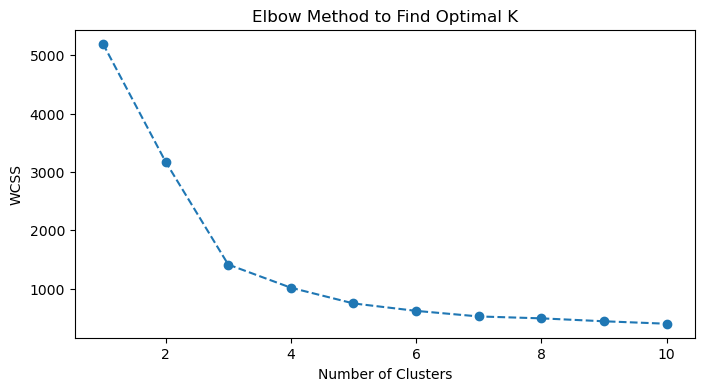

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method to Find Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [25]:
# 5. APPLY K-MEANS
# Change n_clusters based on where the 'elbow' appears in the plot above
k = 3 
model = KMeans(n_clusters=k, init='k-means++', random_state=42)
df['Cluster'] = model.fit_predict(scaled_features)

sns.scatterplot() =
 This function creates a scatter plot
 Each point represents one data record
x=features.iloc[:, 0]=
  features → DataFrame containing feature columns
  .iloc[:, 0] → all rows, 1st column
y=features.iloc[:, 1]
. iloc[:, 1] → all rows, 2nd column
 ➡️ Y-axis = second feature
hue=df['Cluster']
   MOST IMPORTANT for clustering 👈
 hue separates data points by color
 df['Cluster'] contains:
 Cluster labels (0, 1, 2, …) Without hue: ❌ All points same color → no cluster visibility
With hue: ✅ Clearly shows cluster groups
palette='viridis'
Color scheme used for clusters

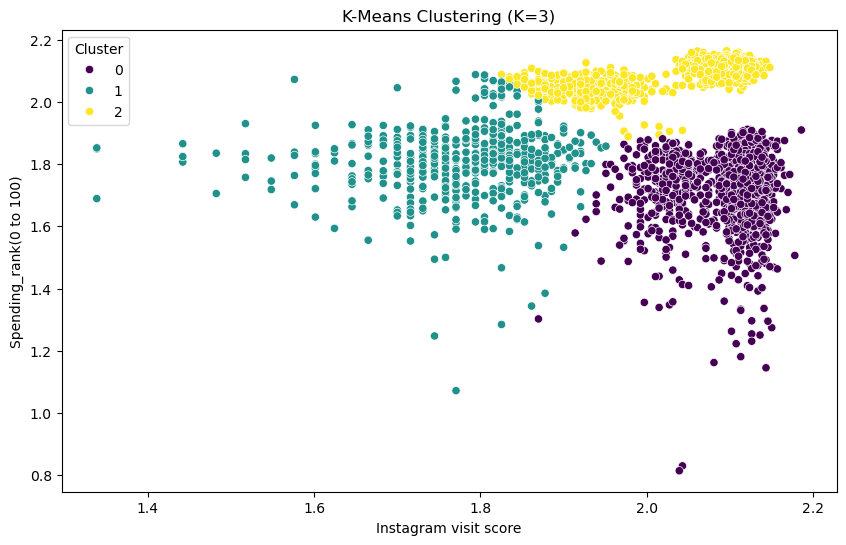

In [26]:
# 6. VISUALIZE RESULTS
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features.iloc[:, 0], y=features.iloc[:, 1], hue=df['Cluster'], palette='viridis')
plt.title(f'K-Means Clustering (K={k})')
plt.show()

🔵 Cluster 0 (Purple) — High Visit, Low–Medium Spending

High Instagram visit score (~2.0–2.2) ,Lower spending rank (~1.2–1.8)

🧠 Interpretation = These users are very active on Instagram but spend less.
🏷️ Cluster Name = 👉 “Active Browsers”
User Type= Content consumers/Browsers/Scroll-heavy users

💼 Business Strategy = Monetize via/Ads/Sponsored posts

Engagement-based campaigns= Introduce/Discounts/Limited-time offers/Gamification

🟢 Cluster 1 (Teal) — Moderate Visit, Moderate Spending

Medium visit score (~1.6–1.9), Medium spending rank (~1.5–1.9)

🧠 Interpretation

These users show balanced behavior — neither extreme.

👥 User Type = Regular users/Potential converters/Stable engagement

💼 Business Strategy = 

Nurture with:Personalized recommendations/Loyalty programs/Influencer marketing

🏷️ Cluster Name = 👉 “Growth Potential Users”


🟡 Cluster 2 (Yellow) — High Visit, High Spending

📍 Location on plot: High visit score (~1.9–2.2),High spending rank (~2.0–2.2)

🧠 Interpretation

These users are highly engaged and high spenders — most valuable segment.

👥 User Type= Power users/Premium customers/Brand loyalists

💼 Business Strategy

Focus on: Premium features/Exclusive offers/Early access launches/Brand partnerships

🏷️ Cluster Name

👉 “Premium Power Users”

In [27]:
print("Clustering Complete! Here are the first few rows with cluster labels:")
print(df.head())

Clustering Complete! Here are the first few rows with cluster labels:
   User ID  Instagram visit score  Spending_rank(0 to 100)  Cluster
0        0               2.039334                 1.794687        0
1        1               2.031535                 1.807387        0
2        2               2.157304                 1.723909        0
3        3               2.102104                 2.115677        2
4        4               1.645615                 1.865745        1


Users in Cluster 0 = Have similar Instagram visits Have similar spending behavior.
User in Cluster 2 = Different behavior from cluster 0 More spending or higher engageme.
 User in Cluster 1 = Lower Instagram visits Moderate spending.
Cluster	Interpretation
0	Medium visit, low spending
1	Low visit, moderate spending
2	High visit, high spending

In [28]:
score = silhouette_score(scaled_features, df['Cluster'])
print(f'Silhouette Score: {score:.3f}')

Silhouette Score: 0.568


How close a data point is to its own cluster (cohesion)
How far it is from other clusters (separation)
Silhouette Score = Silhouette Score measures how good your clustering is.
,Are points well matched with their own cluster and clearly separated from others?
Measures cluster quality

In [29]:
print(f'Inertia (WCSS): {model.inertia_:.2f}')

Inertia (WCSS): 1412.19


Inertia measures how tight the clusters are.
Definition:
Inertia is the sum of squared distances between each data point and its nearest cluster centroid.

In [30]:
db_index = davies_bouldin_score(scaled_features, df['Cluster'])
print(f'Davies-Bouldin Index: {db_index:.3f}')

Davies-Bouldin Index: 0.604


What is Davies–Bouldin Score?
Davies–Bouldin Score measures how similar clusters are to each other.

👉 In simple words:
It checks cluster overlap.
It looks at
Cluster compactness (how tight each cluster is)
Cluster separation (how far clusters are from each other)
2️⃣ Key rule to remember 🧠
🔥 Lower Davies–Bouldin Score = Better clustering
DB Score	Meaning
0       	Perfect clustering
< 1   	Very good clusters
1 – 2	  Acceptable
> 2	Poor     overlapping clusters

In [31]:
#Metric  	Range	  What is "Good"?
#Silhouette Score	 -1 to 1	         Closer to 1
#Inertia (WCSS)    0 to $\infty$        Lower (at the elbow point)
#Davies-Bouldin    0 to $\infty$        Closer to 0

In [32]:
# Group by the cluster and look at the mean of your features
profile = df.groupby('Cluster')[['Instagram visit score', 'Spending_rank(0 to 100)']].mean()
print(profile)
#Cluster 0: High Instagram score, Low Spending (The "Window Shoppers")
#Cluster 1: High Instagram score, High Spending (The "VIP Influencers")
#Cluster 2: Low Instagram score, High Spending (The "Old School Big Spenders")



         Instagram visit score  Spending_rank(0 to 100)
Cluster                                                
0                     2.094449                 1.716844
1                     1.779675                 1.805994
2                     2.030831                 2.084319
